In [1]:
import warnings
warnings.filterwarnings("ignore")
import cv2
import numpy as np
import pandas as pd
import tensorflow as tf
import tensorflow.keras.layers as L
import tensorflow_addons as tfa

import glob, random, os, warnings
import matplotlib.pyplot as plt
from sklearn.metrics import confusion_matrix, classification_report
import seaborn as sns

tf.keras.utils.set_random_seed(1)
tf.config.experimental.enable_op_determinism()

print('TensorFlow Version ' + tf.__version__)
print("Python Version:", tf.__version__)
# print("Keras Version:", tf.keras.__version__)
print("CuDNN Version:", tf.sysconfig.get_build_info())
print("CUDA Version:", tf.sysconfig.get_build_info())


# tf.compat.v1.disable_eager_execution()


def seed_everything(seed = 0):
    random.seed(seed)
    np.random.seed(seed)
    tf.random.set_seed(seed)
    os.environ['PYTHONHASHSEED'] = str(seed)
    os.environ['TF_DETERMINISTIC_OPS'] = '1'

seed_everything()




2024-09-25 14:54:32.957219: E external/local_xla/xla/stream_executor/cuda/cuda_dnn.cc:9261] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
2024-09-25 14:54:32.957324: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:607] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
2024-09-25 14:54:32.958182: E external/local_xla/xla/stream_executor/cuda/cuda_blas.cc:1515] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered
2024-09-25 14:54:32.964397: I tensorflow/core/platform/cpu_feature_guard.cc:182] This TensorFlow binary is optimized to use available CPU instructions in performance-critical operations.
To enable the following instructions: AVX2 FMA, in other operations, rebuild TensorFlow with the appropriate compiler flags.
2024-09-25 14:54:33.662125: W tensorflow/compiler/tf2

TensorFlow Version 2.15.0
Python Version: 2.15.0
CuDNN Version: OrderedDict([('cpu_compiler', '/usr/lib/llvm-17/bin/clang'), ('cuda_compute_capabilities', ['sm_50', 'sm_60', 'sm_70', 'sm_75', 'compute_80']), ('cuda_version', '12.2'), ('cudnn_version', '8'), ('is_cuda_build', True), ('is_rocm_build', False), ('is_tensorrt_build', True)])
CUDA Version: OrderedDict([('cpu_compiler', '/usr/lib/llvm-17/bin/clang'), ('cuda_compute_capabilities', ['sm_50', 'sm_60', 'sm_70', 'sm_75', 'compute_80']), ('cuda_version', '12.2'), ('cudnn_version', '8'), ('is_cuda_build', True), ('is_rocm_build', False), ('is_tensorrt_build', True)])


In [2]:
def data_augment(image):
    seed_everything()
    p_spatial = tf.random.uniform([], 0, 1.0, dtype = tf.float32)
    p_rotate = tf.random.uniform([], 0, 1.0, dtype = tf.float32)
    p_pixel_1 = tf.random.uniform([], 0, 1.0, dtype = tf.float32)
    p_pixel_2 = tf.random.uniform([], 0, 1.0, dtype = tf.float32)
    p_pixel_3 = tf.random.uniform([], 0, 1.0, dtype = tf.float32)
    
    # Flips
    image = tf.image.random_flip_left_right(image)
    image = tf.image.random_flip_up_down(image)
    
    if p_spatial > .75:
        image = tf.image.transpose(image)
        
    # Rotates
    if p_rotate > .75:
        image = tf.image.rot90(image, k = 3) # rotate 270º
    elif p_rotate > .5:
        image = tf.image.rot90(image, k = 2) # rotate 180º
    elif p_rotate > .25:
        image = tf.image.rot90(image, k = 1) # rotate 90º
        
    # Pixel-level transforms
    if p_pixel_1 >= .4:
        image = tf.image.random_saturation(image, lower = .7, upper = 1.3)
    if p_pixel_2 >= .4:
        image = tf.image.random_contrast(image, lower = .8, upper = 1.2)
    if p_pixel_3 >= .4:
        image = tf.image.random_brightness(image, max_delta = .1)
        
    return image

In [3]:

datagen = tf.keras.preprocessing.image.ImageDataGenerator(rescale = 1./255,
                                                          samplewise_center = True,
                                                          samplewise_std_normalization = True,
                                                          validation_split = 0.2,
                                                          preprocessing_function = data_augment,
                                                          )

# # set as training data
# train_gen  = datagen.flow_from_directory(
#     train_path,
#     target_size=(224, 224),
#     batch_size = batch_size,
#     seed = 1,
#     color_mode = 'rgb',
#     shuffle = True,
#     class_mode='categorical',
#     subset='training') 

# # same directory as training data

# valid_gen  = datagen.flow_from_directory(
#     train_path ,
#     target_size=(224, 224),
#     batch_size = batch_size,
#     seed = 1,
#     color_mode = 'rgb',
#     shuffle = False,
#     class_mode='categorical',
#     subset='validation')



In [4]:
image_size = 384
batch_size = 30
n_classes = 10
EPOCHS = 15

classes = {0 : "Pure Ocean Waves",
           1 : "Wind Streaks",
           2 : "Micro Convective Cells",
           3 : "Rain Cells",
           4 : "Biological Slicks",
           5 : "Sea Ice",
           6 : "Icebergs",
           7 : "Low Wind Area",
           8 : "Atmospheric Front",
           9 : "Oceanic Front",
           }

In [5]:
from vit_keras import vit,utils, visualize

vit_model = vit.vit_l32(
    image_size=image_size,
    activation='sigmoid',
    pretrained=True,
    include_top=True,
    pretrained_top=False,
    classes=10)

2024-09-25 14:54:35.451141: I external/local_xla/xla/stream_executor/cuda/cuda_executor.cc:887] could not open file to read NUMA node: /sys/bus/pci/devices/0000:0a:00.0/numa_node
Your kernel may have been built without NUMA support.
2024-09-25 14:54:35.451247: I external/local_xla/xla/stream_executor/cuda/cuda_executor.cc:887] could not open file to read NUMA node: /sys/bus/pci/devices/0000:04:00.0/numa_node
Your kernel may have been built without NUMA support.
2024-09-25 14:54:35.483008: I external/local_xla/xla/stream_executor/cuda/cuda_executor.cc:887] could not open file to read NUMA node: /sys/bus/pci/devices/0000:0a:00.0/numa_node
Your kernel may have been built without NUMA support.
2024-09-25 14:54:35.483073: I external/local_xla/xla/stream_executor/cuda/cuda_executor.cc:887] could not open file to read NUMA node: /sys/bus/pci/devices/0000:04:00.0/numa_node
Your kernel may have been built without NUMA support.
2024-09-25 14:54:35.483111: I external/local_xla/xla/stream_executor

In [6]:
model = tf.keras.Sequential([
        vit_model,
        tf.keras.layers.Flatten(),
        tf.keras.layers.BatchNormalization(),
        tf.keras.layers.Dense(128, activation = tfa.activations.gelu),
        tf.keras.layers.BatchNormalization(),
        tf.keras.layers.Dense(64, activation = tfa.activations.gelu),
        tf.keras.layers.Dense(32, activation = tfa.activations.gelu),
        tf.keras.layers.Dense(10, 'softmax')
    ],
    name = 'vision_transformer')

model.summary()

Model: "vision_transformer"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 vit-l32 (Functional)        (None, 10)                305617930 
                                                                 
 flatten (Flatten)           (None, 10)                0         
                                                                 
 batch_normalization (Batch  (None, 10)                40        
 Normalization)                                                  
                                                                 
 dense (Dense)               (None, 128)               1408      
                                                                 
 batch_normalization_1 (Bat  (None, 128)               512       
 chNormalization)                                                
                                                                 
 dense_1 (Dense)             (None, 64)         

In [7]:
model = tf.keras.models.load_model('/mnt/e/Projects/SAR_Training/Ten_events_classification/1199T8V2Archived/ViTmodel_l32_384_T8V2_1199.keras',safe_mode=False)
model.summary()

Model: "vision_transformer"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 vit-l32 (Functional)        (None, 10)                305617930 
                                                                 
 flatten (Flatten)           (None, 10)                0         
                                                                 
 batch_normalization (Batch  (None, 10)                40        
 Normalization)                                                  
                                                                 
 dense (Dense)               (None, 128)               1408      
                                                                 
 batch_normalization_1 (Bat  (None, 128)               512       
 chNormalization)                                                
                                                                 
 dense_1 (Dense)             (None, 64)         

In [8]:
# model.load_weights('/mnt/e/Projects/SAR_Training/Ten_events_classification/ViTmodel_l32_384.keras')

# Manual Test for Success cases, image for paper

In [23]:
# test_path = '/mnt/e/Projects/SAR_Training/Ten_events_classification/Data/Used in paper/Manual Test - suc'
# test_path = '/mnt/e/Projects/SAR_Training/Ten_events_classification/Data//Used in paper/Manual Test - fail'
# test_path = '/mnt/e/Projects/SAR_Training/Ten_events_classification/Data//Used in paper/Sea Ice Test'
test_path = '/mnt/e/Projects/SAR_Training/Ten_events_classification/Data/Balanced/Test'

# datagen = tf.keras.preprocessing.image.ImageDataGenerator(rescale = 1./255,
#                                                           samplewise_center = True,
#                                                           samplewise_std_normalization = True,
#                                                           validation_split = 0.2,
#                                                           preprocessing_function = data_augment,
#                                                           )


test_gen  = datagen.flow_from_directory(
    test_path ,
    target_size=(384, 384),
    batch_size = 1,
    seed = 1,
    color_mode = 'rgb',
    shuffle = False,
    # class_mode='categorical',
    )


Found 5000 images belonging to 10 classes.


In [10]:
class_names = list(classes.values())
class_names

class_names_abbrev = ['PureWaves',
 'WindStreaks',
 'MicroCells',
 'RainCells',
 'BioSlicks',
 'SeaIce',
 'Icebergs',
 'Low Wind',
 'AtmFront',
 'OcnFront']

In [11]:
def plot_image(i, predictions_array, true_label, img):
  true_label, img = true_label, img
  # true_label, img = 9, img[i]
  plt.grid(False)
  plt.xticks([])
  plt.yticks([])

  plt.imshow(img, cmap=plt.cm.binary)
  # plt.imshow(img)

  predicted_label = np.argmax(predictions_array)
  if predicted_label == true_label:
    color = 'blue'
  else:
    color = 'red'

  plt.xlabel("{} {:2.0f}%\n({})".format(class_names[predicted_label],
                                100*np.max(predictions_array),
                                class_names[true_label]),
                                color=color)

def plot_value_array(i, predictions_array, true_label):

  yticks = [0, 0.2, 0.4, 0.6, 0.8, 1.0]
  ytick_labels = ['0', '20%', '40%', '60%', '80%', '100%']
  predicted_label = np.argmax(predictions_array)
  # true_label = true_label[i]
  plt.grid(False)
  plt.xticks(rotation=90, ha='right')
  plt.yticks(yticks, ytick_labels)
  thisplot = plt.bar(class_names_abbrev, predictions_array, color="#777777")
  plt.ylim([0, 1])
  predicted_label = np.argmax(predictions_array)

  thisplot[predicted_label].set_color('red')
  thisplot[true_label].set_color('blue')

In [12]:
from vit_keras import vit,layers
def attention_map_view(model, image):
    """Get an attention map for an image and model using the technique
    described in Appendix D.7 in the paper (unofficial).

    Args:
        model: A ViT model
        image: An image for which we will compute the attention map.
    """
    img_height, img_width = model.input_shape[1], model.input_shape[2]
    grid_size = int(np.sqrt(model.layers[5].output_shape[0][-2] - 1))

    # Prepare the input
    X = vit.preprocess_inputs(cv2.resize(image, (img_height, img_width)))[np.newaxis, :]  # type: ignore

    # Get the attention weights from each transformer.
    outputs = [
        l.output[1] for l in model.layers if isinstance(l, layers.TransformerBlock)
    ]
    weights = np.array(
        tf.keras.models.Model(inputs=model.inputs, outputs=outputs).predict(X)
    )
    num_layers = weights.shape[0]
    num_heads = weights.shape[2]
    reshaped = weights.reshape(
        (num_layers, num_heads, grid_size**2 + 1, grid_size**2 + 1)
    )

    # From Appendix D.6 in the paper ...
    # Average the attention weights across all heads.
    reshaped = reshaped.mean(axis=1)

    # From Section 3 in https://arxiv.org/pdf/2005.00928.pdf ...
    # To account for residual connections, we add an identity matrix to the
    # attention matrix and re-normalize the weights.
    reshaped = reshaped + np.eye(reshaped.shape[1])
    reshaped = reshaped / reshaped.sum(axis=(1, 2))[:, np.newaxis, np.newaxis]

    # Recursively multiply the weight matrices
    v = reshaped[-1]
    for n in range(1, len(reshaped)):
        v = np.matmul(v, reshaped[-1 - n])

    # Attention from the output token to the input space.
    mask = v[0, 1:].reshape(grid_size, grid_size)
    mask = cv2.resize(mask / mask.max(), (image.shape[1], image.shape[0]))[
        ..., np.newaxis
    ]
    return reshaped, v, mask

## Find the paths and file names

In [13]:
# base_path = '/mnt/e/Projects/SAR_Training/Ten_events_classification/Data/Manual Test'
# subfolders = [chr(i) for i in range(ord('F'), ord('O') + 1)]

# for subfolder in subfolders:
#     folder_path = os.path.join(base_path, subfolder)
#     for file_name in os.listdir(folder_path):
#         file_path = os.path.join(folder_path, file_name)
#         print(f"Folder: {subfolder}, File Name: {file_name}, File Path: {file_path}")

In [24]:
# test_path_image = ['/mnt/e/Projects/SAR_Training/Ten_events_classification/Data/Manual Test/F/s1a-wv1-slc-vv-20160916t101825-20160916t101828-013076-014bd5-003.png',
#                    '/mnt/e/Projects/SAR_Training/Ten_events_classification/Data/Manual Test/G/s1a-wv2-slc-vv-20160702t170632-20160702t170635-011972-012765-044.png',
#                    '/mnt/e/Projects/SAR_Training/Ten_events_classification/Data/Manual Test/H/s1a-wv2-slc-vv-20160912t012431-20160912t012433-013012-0149ba-044.png',
#                    '/mnt/e/Projects/SAR_Training/Ten_events_classification/Data/Manual Test/I/s1a-wv2-slc-vv-20160911t050842-20160911t050845-013000-014953-022.png',
#                    '/mnt/e/Projects/SAR_Training/Ten_events_classification/Data/Manual Test/J/s1a-wv1-slc-vv-20161127t204956-20161127t204959-014132-016d11-023.png',
#                    '/mnt/e/Projects/SAR_Training/Ten_events_classification/Data/Manual Test/K/s1a-wv1-slc-vv-20160101t134935-20160101t134938-009301-00d6fc-109.png',
#                    '/mnt/e/Projects/SAR_Training/Ten_events_classification/Data/Manual Test/L/s1a-wv1-slc-vv-20161217t141121-20161217t141124-014420-017614-101.png',
#                    '/mnt/e/Projects/SAR_Training/Ten_events_classification/Data/Manual Test/M/s1a-wv1-slc-vv-20161006t154306-20161006t154309-013371-01554b-103.png',
#                    '/mnt/e/Projects/SAR_Training/Ten_events_classification/Data/Manual Test/N/s1a-wv2-slc-vv-20160422t081412-20160422t081415-010931-01064c-032.png',
#                    '/mnt/e/Projects/SAR_Training/Ten_events_classification/Data/Manual Test/O/s1a-wv1-slc-vv-20160119t172855-20160119t172858-009566-00de95-031.png',
# ]
test_path_image = test_gen.filepaths

1/1 [==============================] - 4s 4s/step


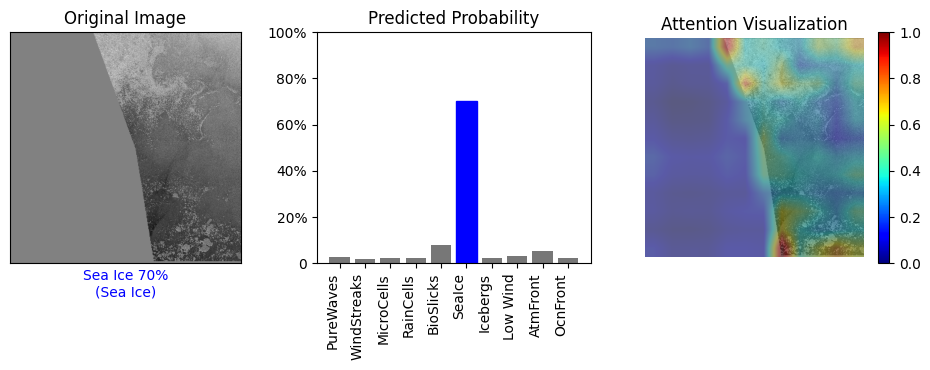

1/1 [==============================] - 4s 4s/step


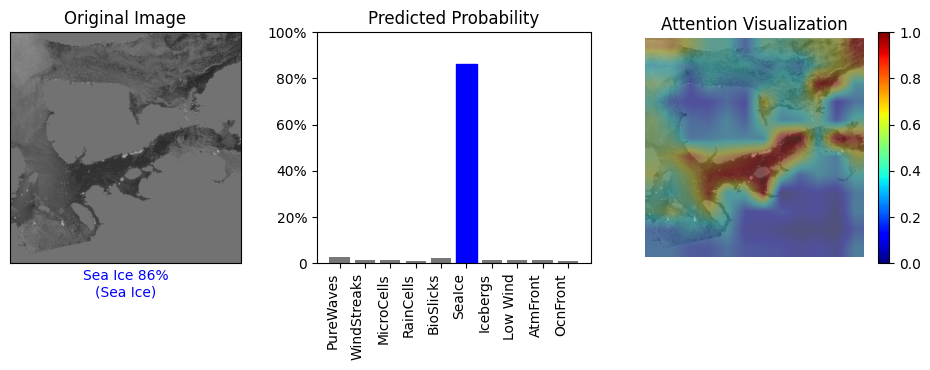

1/1 [==============================] - 4s 4s/step


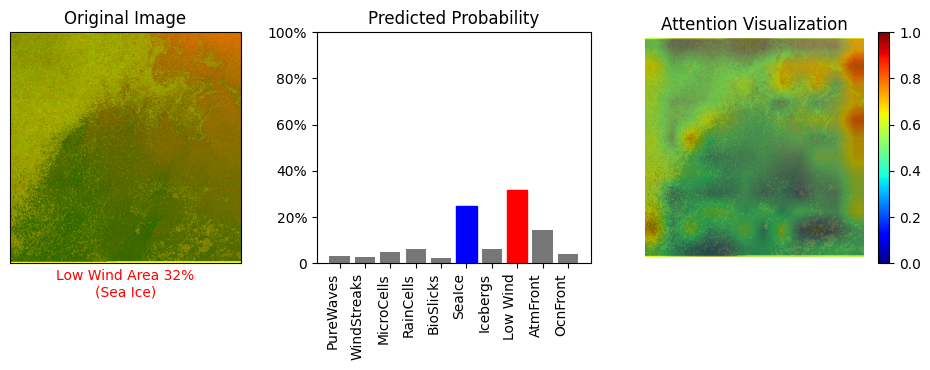

1/1 [==============================] - 4s 4s/step


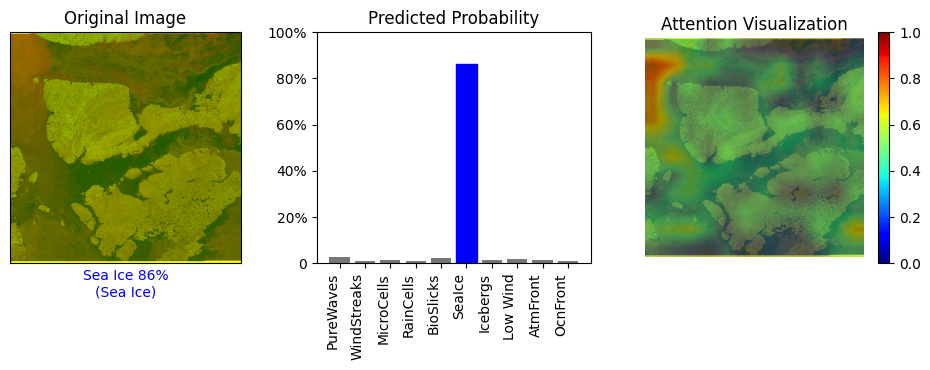

In [22]:
from vit_keras import vit,utils, visualize

predicted_classes = model.predict(test_gen)
output_dir = '/mnt/e/Projects/SAR_Training/Ten_events_classification/Data/Used in paper/'
for i in range(0,len(predicted_classes)):

    true_label = np.where(test_gen[i][1][0] == 1)[0][0]
    
    image = utils.read(test_path_image[i], 384)
    image_flat = ((image[:, :, 0] - np.min(image[:, :, 0])) / (np.max(image[:, :, 0]) - np.min(image[:, :, 0]))).flatten()
    attention_map = visualize.attention_map(model=model.layers[0], image=image)
    reshaped, v, attention_map2 = attention_map_view(model=model.layers[0], image=image)
    # attention_map_flat = attention_image.flatten()

    # print('Prediction:', classes[
    #     model.predict(vit.preprocess_inputs(image)[np.newaxis])[0].argmax()]
    # )  

    attention_image = attention_map.mean(axis=-1)
    attention_image = (attention_image - np.min(attention_image)) / (np.max(attention_image) - np.min(attention_image))

    attention_image2 = attention_map2.mean(axis=-1)
    attention_image2 = (attention_image2 - np.min(attention_image2)) / (np.max(attention_image2) - np.min(attention_image2))
    attention_map_flat = attention_image.flatten()
    

    heatmap2 = cv2.applyColorMap((attention_image2* 255).astype(np.uint8), cv2.COLORMAP_JET)

    # Overlay the heatmap on the original image
    # overlayed_image = cv2.addWeighted(cv2.cvtColor(image, cv2.COLOR_RGB2BGR), 0.8, heatmap, 0.4, 0)

    overlayed_image2 = cv2.addWeighted(cv2.cvtColor(image, cv2.COLOR_RGB2BGR), 0.7, heatmap2, 0.3, 0)

    plt.figure(figsize=(12,3))
    plt.subplot(1,3,1)
    plot_image(i, predicted_classes[i], true_label, image)
    plt.title('Original Image')
    plt.subplot(1,3,2)
    plot_value_array(i, predicted_classes[i],  true_label)
    plt.title('Predicted Probability')
    # plt.subplot(1,3,3)
    # plt.imshow(attention_image, cmap='viridis', aspect='auto', vmin=0, vmax=1)
    plt.subplot(1, 3, 3)
    plt.imshow(cv2.cvtColor(overlayed_image2, cv2.COLOR_BGR2RGB),cmap='jet',vmin=0, vmax=1)
    # plt.title("Attention Visualization Overlayed")
    plt.axis('off')
    plt.colorbar()
    plt.title('Attention Visualization')
    plt.grid(False)
    plt.xticks([])
    plt.yticks([])

    input_filepath = test_path_image[i]
    input_filename = os.path.basename(input_filepath)
    output_filename = os.path.splitext(input_filename)[0] + '.png'

    # Save the figure to the specified directory
    plt.savefig(os.path.join(output_dir, output_filename),bbox_inches='tight',dpi=600)
    plt.show()


### Save supplemantary images.

# Image for failed tests

In [147]:
test_path = '/mnt/e/Projects/SAR_Training/Ten_events_classification/Data/Manual Test - fail'

test_gen  = datagen.flow_from_directory(
    test_path ,
    target_size=(384, 384),
    batch_size = 1,
    seed = 1,
    color_mode = 'rgb',
    shuffle = False,
    # class_mode='categorical',
    )

test_path_image = test_gen.filepaths

predicted_classes = model.predict(test_gen)
class_names = list(classes.values())

class_names_abbrev = ['PureWaves',
 'WindStreaks',
 'MicroCells',
 'RainCells',
 'BioSlicks',
 'SeaIce',
 'Icebergs',
 'Low Wind',
 'AtmFront',
 'OcnFront']


Found 9 images belonging to 10 classes.
9/9 [==============================] - 14s 2s/step


In [146]:
# test_filepath = test_gen.filepaths
# test_filepath

['/mnt/e/Projects/SAR_Training/Ten_events_classification/Data/Manual Test - fail/F/s1a-wv1-slc-vv-20161007t033934-20161007t033937-013378-01558f-019.png',
 '/mnt/e/Projects/SAR_Training/Ten_events_classification/Data/Manual Test - fail/G/s1a-wv2-slc-vv-20160708t161741-20160708t161744-012059-012a56-004.png',
 '/mnt/e/Projects/SAR_Training/Ten_events_classification/Data/Manual Test - fail/H/s1a-wv2-slc-vv-20160915t154927-20160915t154930-013065-014b6c-032.png',
 '/mnt/e/Projects/SAR_Training/Ten_events_classification/Data/Manual Test - fail/I/s1a-wv2-slc-vv-20160920t092006-20160920t092008-013134-014dc8-010.png',
 '/mnt/e/Projects/SAR_Training/Ten_events_classification/Data/Manual Test - fail/J/s1a-wv1-slc-vv-20161124t020509-20161124t020512-014077-016b54-039.png',
 '/mnt/e/Projects/SAR_Training/Ten_events_classification/Data/Manual Test - fail/K/s1a-wv2-slc-vv-20160707t061815-20160707t061817-012038-0129ac-010.png',
 '/mnt/e/Projects/SAR_Training/Ten_events_classification/Data/Manual Test - 

In [144]:
# base_path = test_path
# subfolders = [chr(i) for i in range(ord('F'), ord('O') + 1)]

# for subfolder in subfolders:
#     folder_path = os.path.join(base_path, subfolder)
#     for file_name in os.listdir(folder_path):
#         file_path = os.path.join(folder_path, file_name)
#         print(f"Folder: {subfolder}, File Name: {file_name}, File Path: {file_path}")

Folder: F, File Name: s1a-wv1-slc-vv-20161007t033934-20161007t033937-013378-01558f-019.png, File Path: /mnt/e/Projects/SAR_Training/Ten_events_classification/Data/Manual Test - fail/F/s1a-wv1-slc-vv-20161007t033934-20161007t033937-013378-01558f-019.png
Folder: G, File Name: s1a-wv2-slc-vv-20160708t161741-20160708t161744-012059-012a56-004.png, File Path: /mnt/e/Projects/SAR_Training/Ten_events_classification/Data/Manual Test - fail/G/s1a-wv2-slc-vv-20160708t161741-20160708t161744-012059-012a56-004.png
Folder: H, File Name: s1a-wv2-slc-vv-20160915t154927-20160915t154930-013065-014b6c-032.png, File Path: /mnt/e/Projects/SAR_Training/Ten_events_classification/Data/Manual Test - fail/H/s1a-wv2-slc-vv-20160915t154927-20160915t154930-013065-014b6c-032.png
Folder: I, File Name: s1a-wv2-slc-vv-20160920t092006-20160920t092008-013134-014dc8-010.png, File Path: /mnt/e/Projects/SAR_Training/Ten_events_classification/Data/Manual Test - fail/I/s1a-wv2-slc-vv-20160920t092006-20160920t092008-013134-014

1/1 [==============================] - 2s 2s/step
Prediction: Pure Ocean Waves


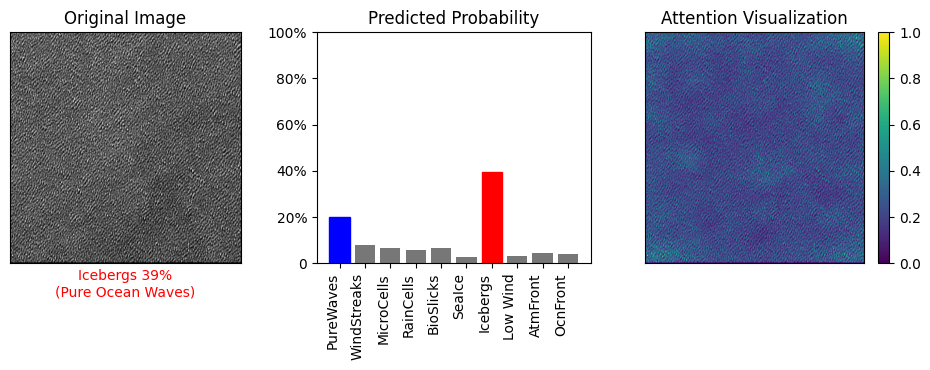

1/1 [==============================] - 2s 2s/step
Prediction: Wind Streaks


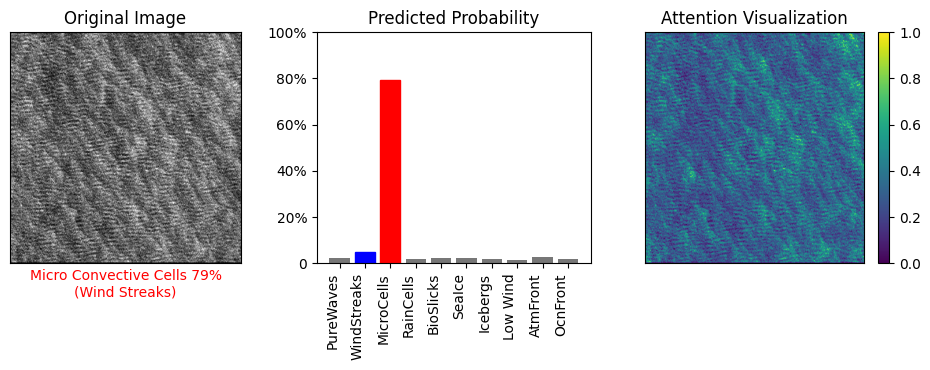

1/1 [==============================] - 2s 2s/step
Prediction: Oceanic Front


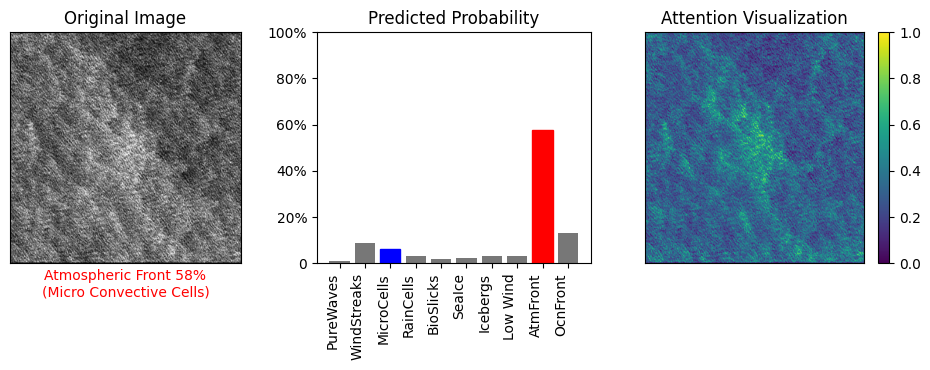

1/1 [==============================] - 2s 2s/step
Prediction: Icebergs


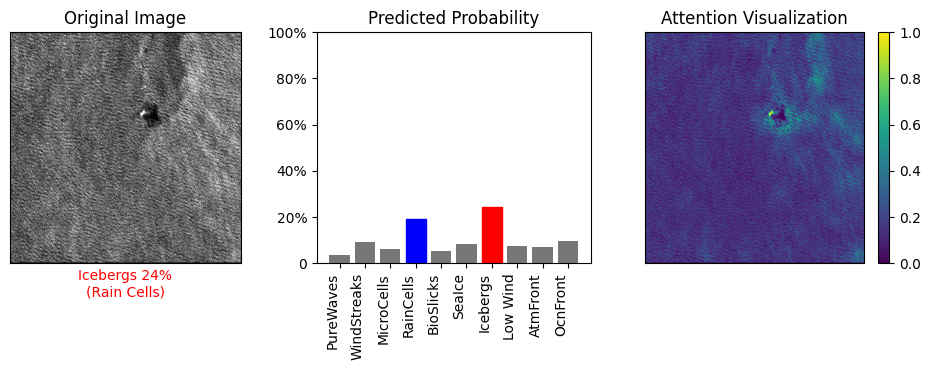

1/1 [==============================] - 2s 2s/step
Prediction: Oceanic Front


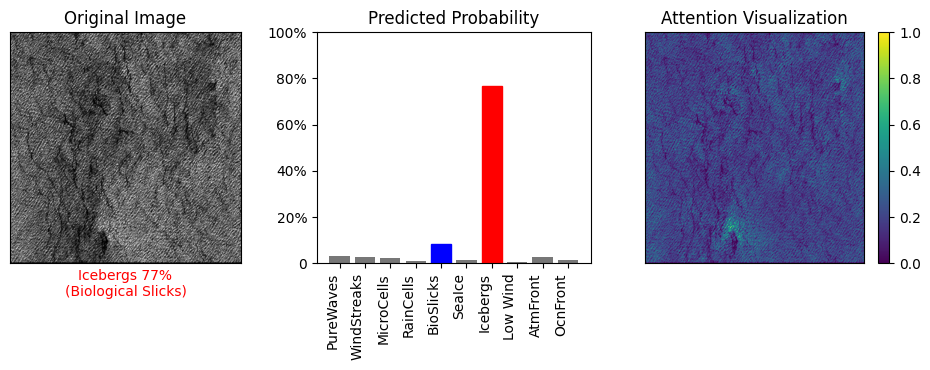

1/1 [==============================] - 2s 2s/step
Prediction: Oceanic Front


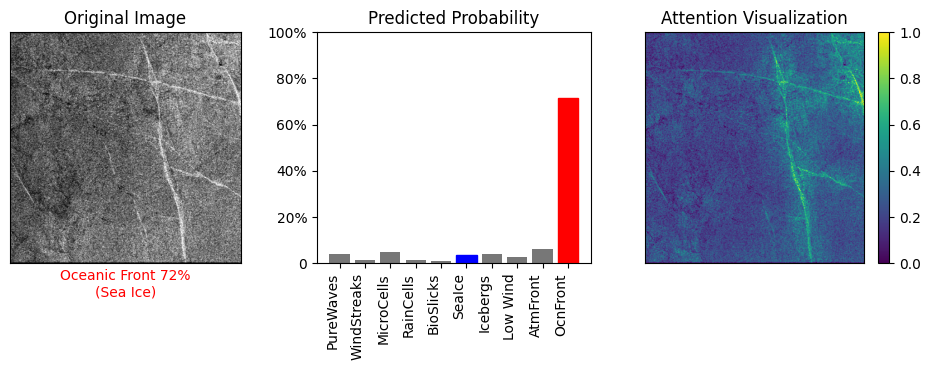

1/1 [==============================] - 2s 2s/step
Prediction: Icebergs


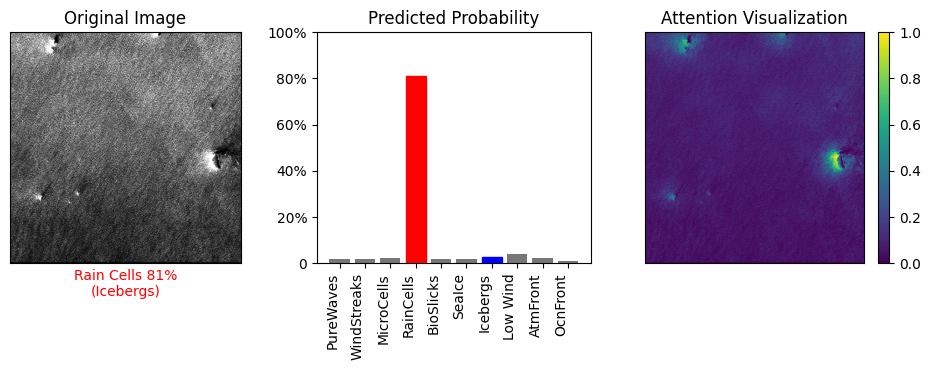

1/1 [==============================] - 2s 2s/step
Prediction: Low Wind Area


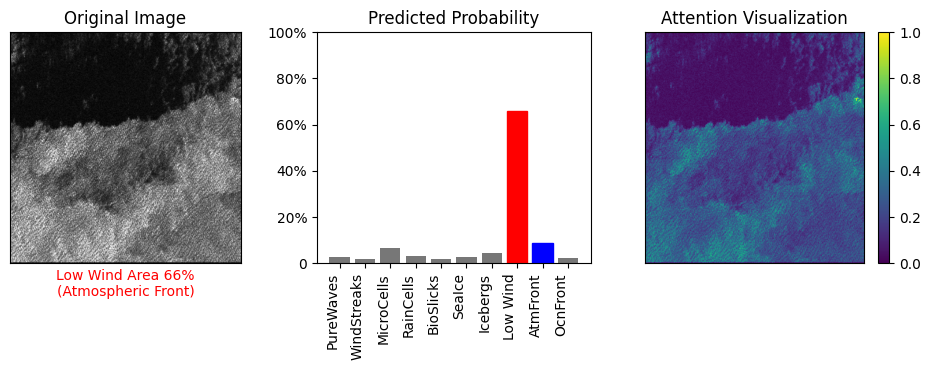

1/1 [==============================] - 2s 2s/step
Prediction: Oceanic Front


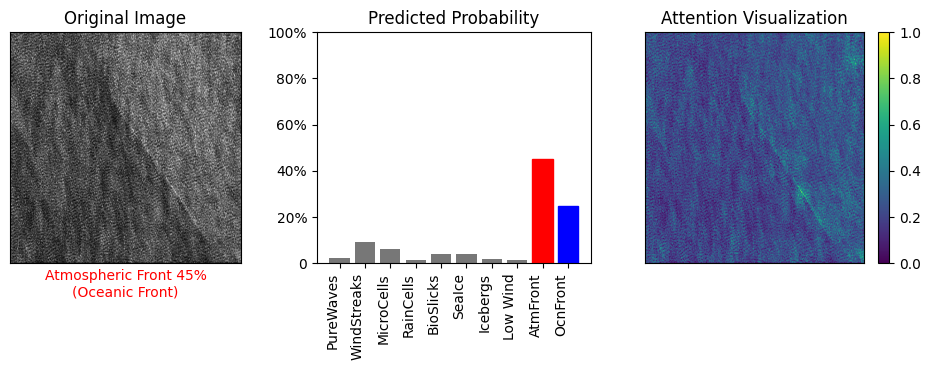

In [148]:
for i in range(0,len(predicted_classes)):

    # test_gen_image = test_gen[i][0]
    true_label = np.where(test_gen[i][1][0] == 1)[0][0]
    
    image = utils.read(test_path_image[i], 384)
    attention_map = visualize.attention_map(model=model.layers[0], image=image)
    print('Prediction:', classes[
        model.predict(vit.preprocess_inputs(image)[np.newaxis])[0].argmax()]
    )  # Prediction: Eskimo dog, husky

    attention_image = attention_map.mean(axis=-1)
    attention_image = (attention_image - np.min(attention_image)) / (np.max(attention_image) - np.min(attention_image))
    # Plot results
    # fig, (ax1, ax2) = plt.subplots(ncols=2)
    # ax1.axis('off')
    # ax2.axis('off')
    # ax1.set_title('Original')
    # ax2.set_title('Attention Map')
    # _ = ax1.imshow(image)
    # _ = ax2.imshow(grayscale_image, cmap='viridis')

    plt.figure(figsize=(12,3))
    plt.subplot(1,3,1)
    plot_image(i, predicted_classes[i], true_label, image)
    plt.title('Original Image')
    plt.subplot(1,3,2)
    plot_value_array(i, predicted_classes[i],  true_label)
    plt.title('Predicted Probability')
    plt.subplot(1,3,3)
    plt.imshow(attention_image, cmap='viridis', aspect='auto', vmin=0, vmax=1)
    plt.colorbar()
    plt.title('Attention Visualization')
    plt.grid(False)
    plt.xticks([])
    plt.yticks([])
    plt.show()

# Test and find the fail samples

In [141]:
dataset_directory = '/mnt/e/Projects/SAR_Training/Ten_events_classification/Data/Balanced/Test'

test_dataset  = datagen.flow_from_directory(
    dataset_directory,
    target_size=(384, 384),
    batch_size = 10,
    seed = 1,
    color_mode = 'rgb',
    shuffle = False,
    # class_mode='categorical',
    )

file_paths = test_dataset.filepaths

Found 5000 images belonging to 10 classes.


In [142]:
# Make predictions
predictions = model.predict(test_dataset)
predicted_labels = np.argmax(predictions, axis=1)

# Find the true labels
true_labels = test_dataset.classes

# Find the incorrect predictions
incorrect_indices = np.where(predicted_labels != true_labels)[0]

# Log the paths of the failed samples
failed_samples = [file_paths[idx] for idx in incorrect_indices]

# Print the paths of the failed samples
for path in failed_samples:
    print(f"Model failed on: {path}")

500/500 [==============================] - 987s 2s/step
Model failed on: /mnt/e/Projects/SAR_Training/Ten_events_classification/Data/Balanced/Test/F/s1a-wv1-slc-vv-20161007t033934-20161007t033937-013378-01558f-019.png
Model failed on: /mnt/e/Projects/SAR_Training/Ten_events_classification/Data/Balanced/Test/F/s1a-wv1-slc-vv-20161008t024016-20161008t024019-013392-0155fa-023.png
Model failed on: /mnt/e/Projects/SAR_Training/Ten_events_classification/Data/Balanced/Test/F/s1a-wv1-slc-vv-20161009t064708-20161009t064711-013409-015689-043.png
Model failed on: /mnt/e/Projects/SAR_Training/Ten_events_classification/Data/Balanced/Test/F/s1a-wv1-slc-vv-20161011t062552-20161011t062555-013438-015781-041.png
Model failed on: /mnt/e/Projects/SAR_Training/Ten_events_classification/Data/Balanced/Test/F/s1a-wv1-slc-vv-20161012t055000-20161012t055003-013452-0157ee-113.png
Model failed on: /mnt/e/Projects/SAR_Training/Ten_events_classification/Data/Balanced/Test/F/s1a-wv1-slc-vv-20161012t195610-20161012t1

In [41]:
model.layers[5].output_shape[1]

64

In [ ]:

# from vit_keras import vit, utils, visualize

# # Load a model
# image_size = 384
# classes = utils.get_imagenet_classes()
# model = vit.vit_b16(
#     image_size=image_size,
#     activation='sigmoid',
#     pretrained=True,
#     include_top=True,
#     pretrained_top=True
# )
# classes = utils.get_imagenet_classes()

# # Get an image and compute the attention map
# url = 'https://upload.wikimedia.org/wikipedia/commons/b/bc/Free%21_%283987584939%29.jpg'
# image = utils.read(url, image_size)
# # image = test_path_image
# attention_map = visualize.attention_map(model=model, image=test_gen)
# print('Prediction:', classes[
#     model.predict(vit.preprocess_inputs(image)[np.newaxis])[0].argmax()]
# )  # Prediction: Eskimo dog, husky

# # Plot results
# fig, (ax1, ax2) = plt.subplots(ncols=2)
# ax1.axis('off')
# ax2.axis('off')
# ax1.set_title('Original')
# ax2.set_title('Attention Map')
# _ = ax1.imshow(image)
# _ = ax2.imshow(attention_map)

### confusion matrix

5001/5001 [==============================] - 10733s 2s/step
              precision    recall  f1-score   support

           0       0.99      0.97      0.98       500
           1       1.00      1.00      1.00       500
           2       1.00      0.99      1.00       500
           3       0.99      0.99      0.99       500
           4       1.00      0.98      0.99       500
           5       0.99      1.00      1.00       500
           6       0.97      0.98      0.98       500
           7       0.98      1.00      0.99       500
           8       0.95      0.99      0.97       500
           9       0.97      0.95      0.96       500

    accuracy                           0.98      5000
   macro avg       0.98      0.98      0.98      5000
weighted avg       0.98      0.98      0.98      5000



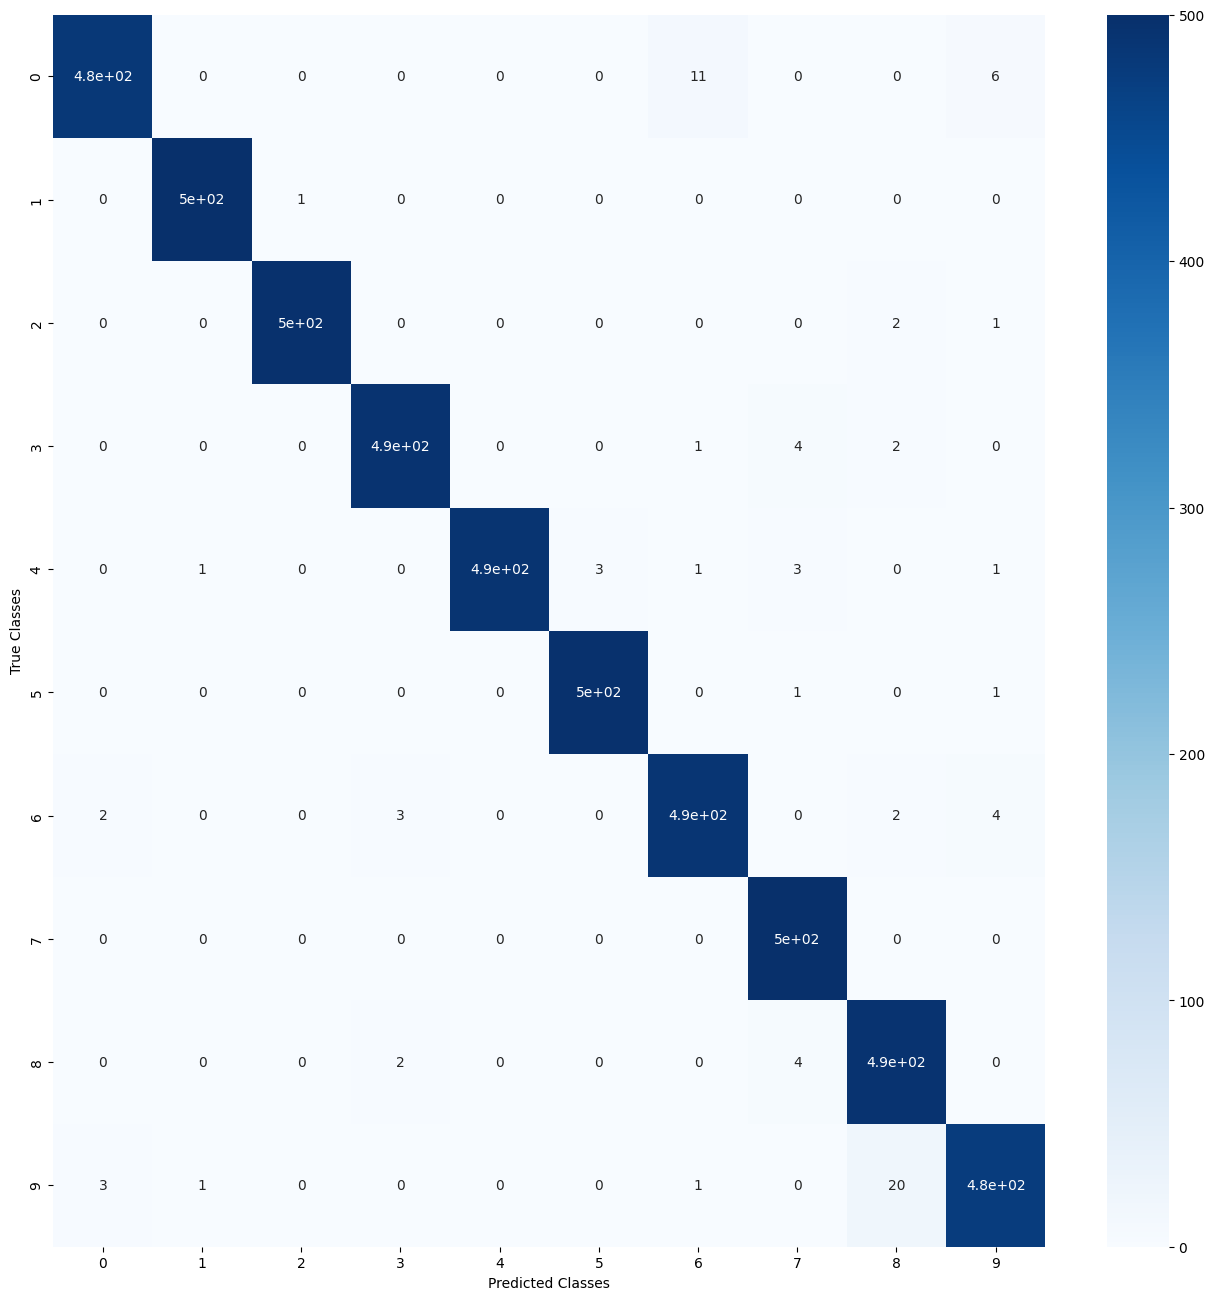

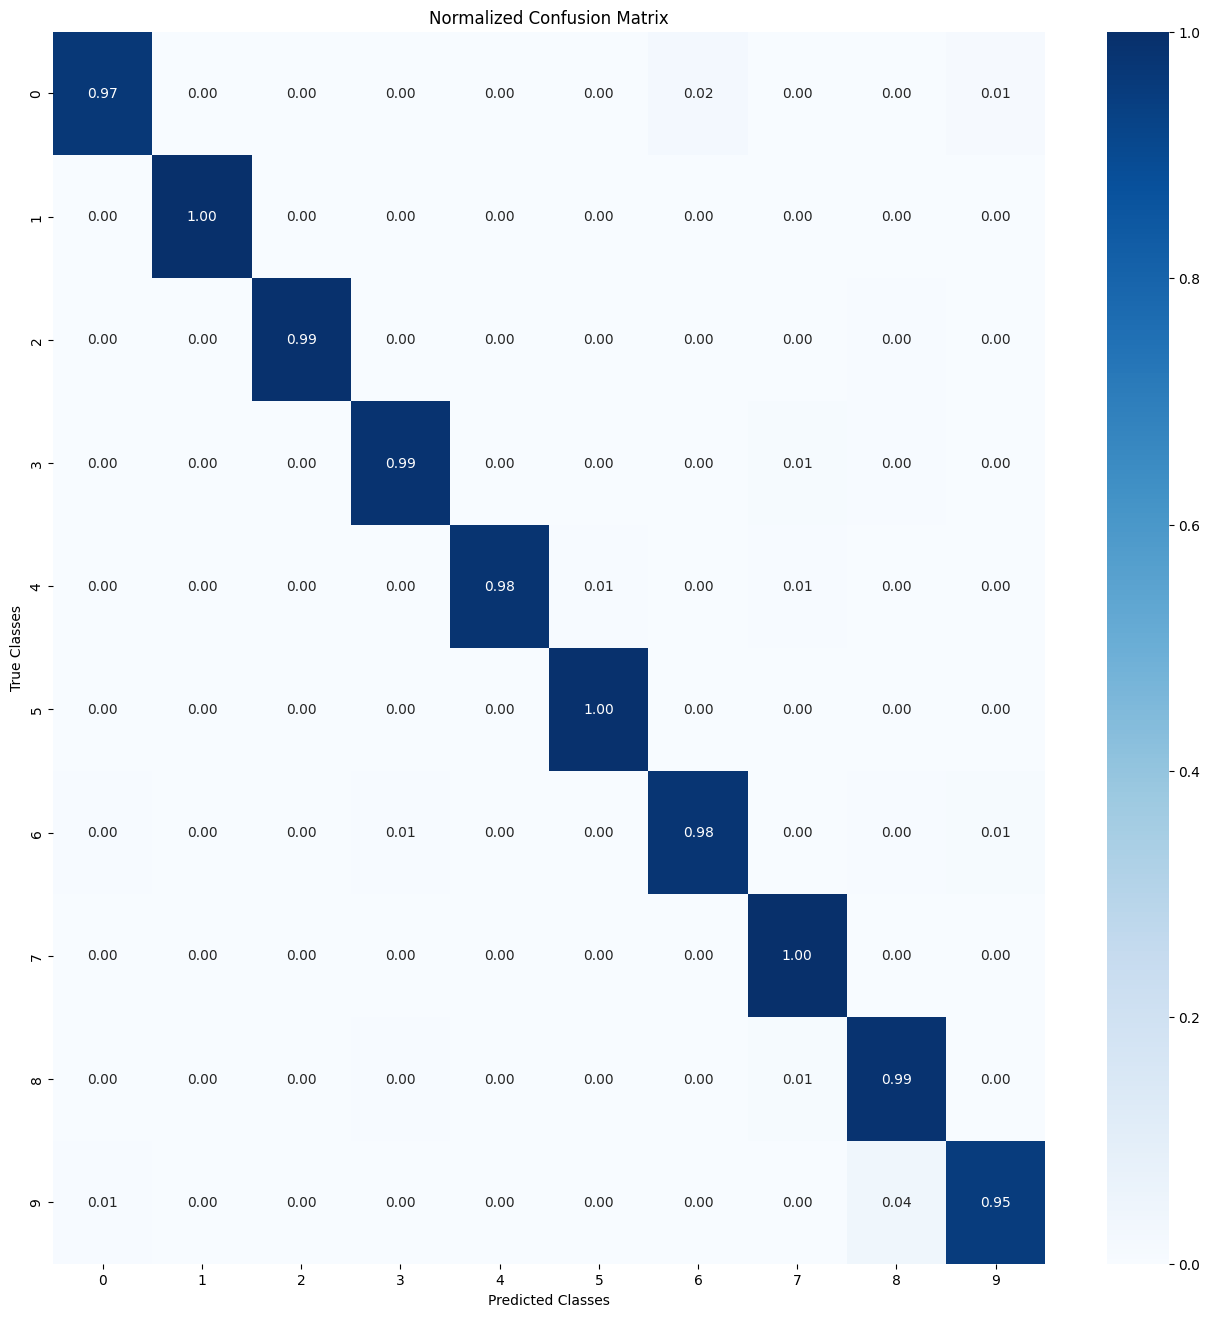

              precision    recall  f1-score   support

           F       0.99      0.97      0.98       500
           G       1.00      1.00      1.00       500
           H       1.00      0.99      1.00       500
           I       0.99      0.99      0.99       500
           J       1.00      0.98      0.99       500
           K       0.99      1.00      1.00       500
           L       0.97      0.98      0.98       500
           M       0.98      1.00      0.99       500
           N       0.95      0.99      0.97       500
           O       0.97      0.95      0.96       500

    accuracy                           0.98      5000
   macro avg       0.98      0.98      0.98      5000
weighted avg       0.98      0.98      0.98      5000



In [25]:
predicted_classes = np.argmax(model.predict(test_gen, steps = test_gen.n // test_gen.batch_size + 1), axis = 1)
true_classes = test_gen.classes
class_labels = list(test_gen.class_indices.keys())  

confusionmatrix = confusion_matrix(true_classes, predicted_classes)
plt.figure(figsize = (16, 16))
sns.heatmap(confusionmatrix, cmap = 'Blues', annot = True, cbar = True)
plt.ylabel('True Classes')
plt.xlabel('Predicted Classes')

print(classification_report(true_classes, predicted_classes))

# Normalize confusion matrix by row (i.e., by the number of true labels in each class)
normalized_confusionmatrix = confusionmatrix.astype('float') / confusionmatrix.sum(axis=1)[:, np.newaxis]

# Plot normalized confusion matrix
plt.figure(figsize=(16, 16))
sns.heatmap(normalized_confusionmatrix, cmap='Blues', annot=True, fmt=".2f", cbar=True)
plt.title('Normalized Confusion Matrix')
plt.ylabel('True Classes')
plt.xlabel('Predicted Classes')
plt.show()
# Print classification report
print(classification_report(true_classes, predicted_classes, target_names=class_labels))

              precision    recall  f1-score   support

           0       0.99      0.97      0.98       500
           1       1.00      1.00      1.00       500
           2       1.00      0.99      1.00       500
           3       0.99      0.99      0.99       500
           4       1.00      0.98      0.99       500
           5       0.99      1.00      1.00       500
           6       0.97      0.98      0.98       500
           7       0.98      1.00      0.99       500
           8       0.95      0.99      0.97       500
           9       0.97      0.95      0.96       500

    accuracy                           0.98      5000
   macro avg       0.98      0.98      0.98      5000
weighted avg       0.98      0.98      0.98      5000



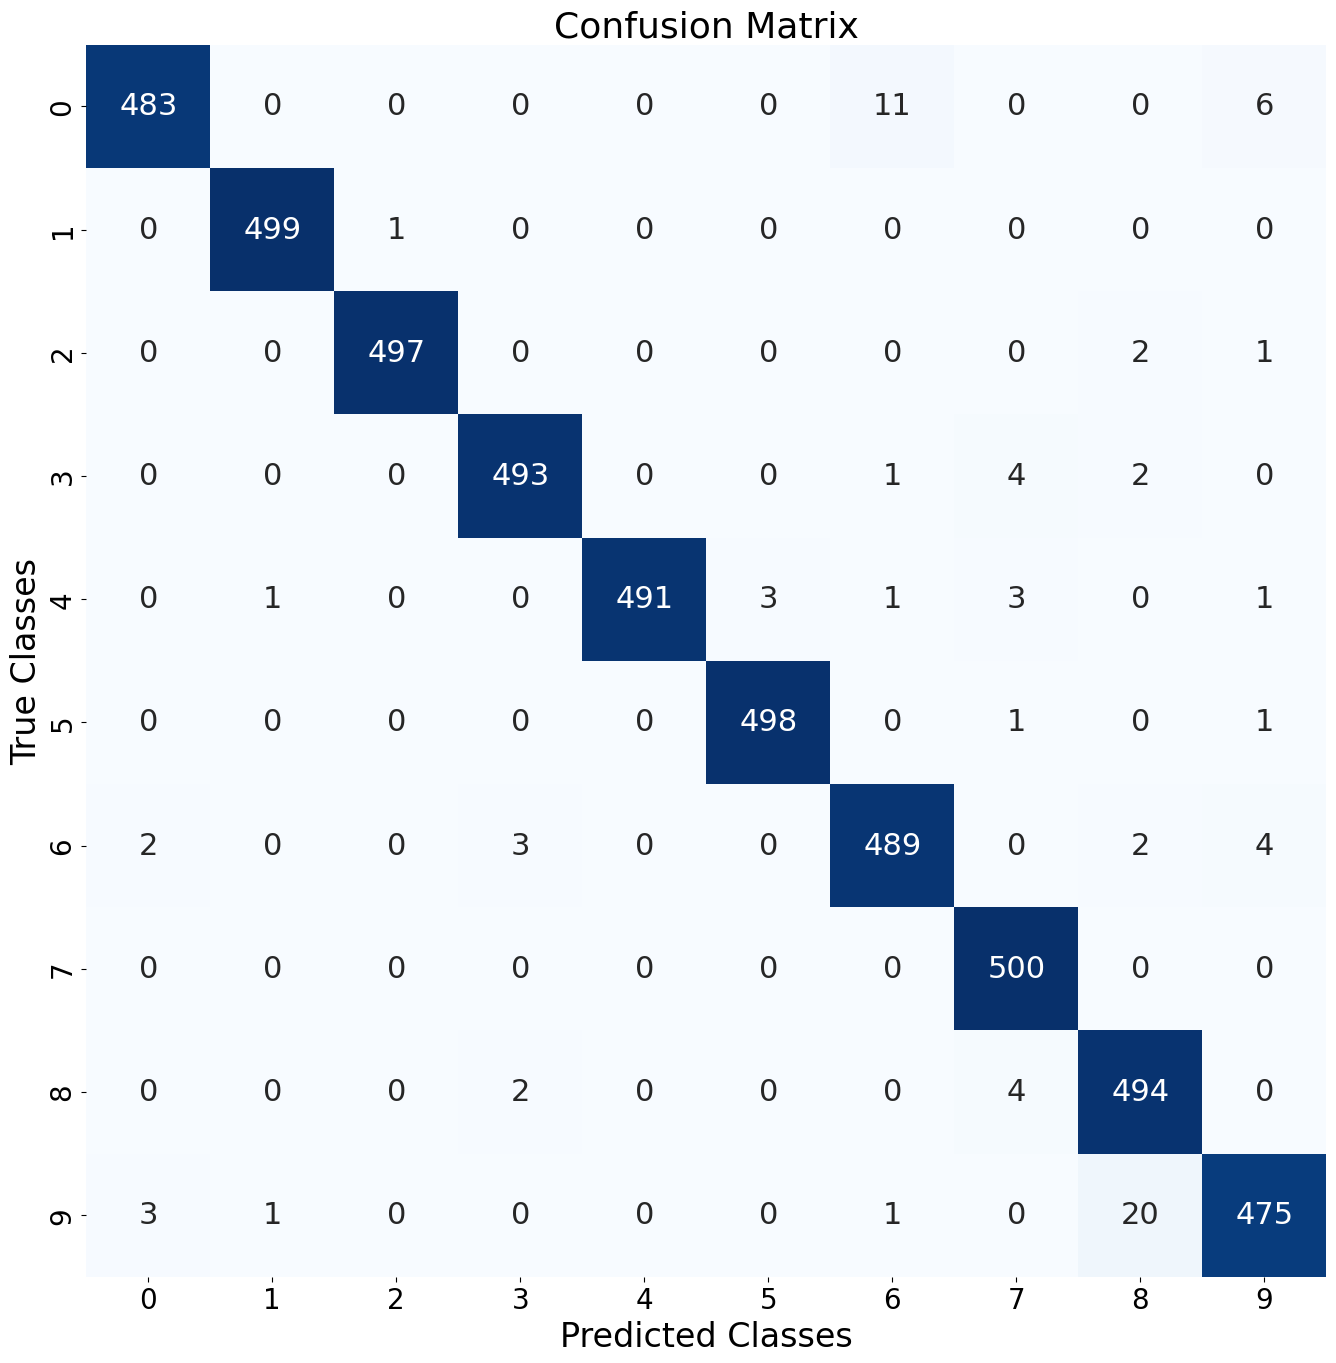

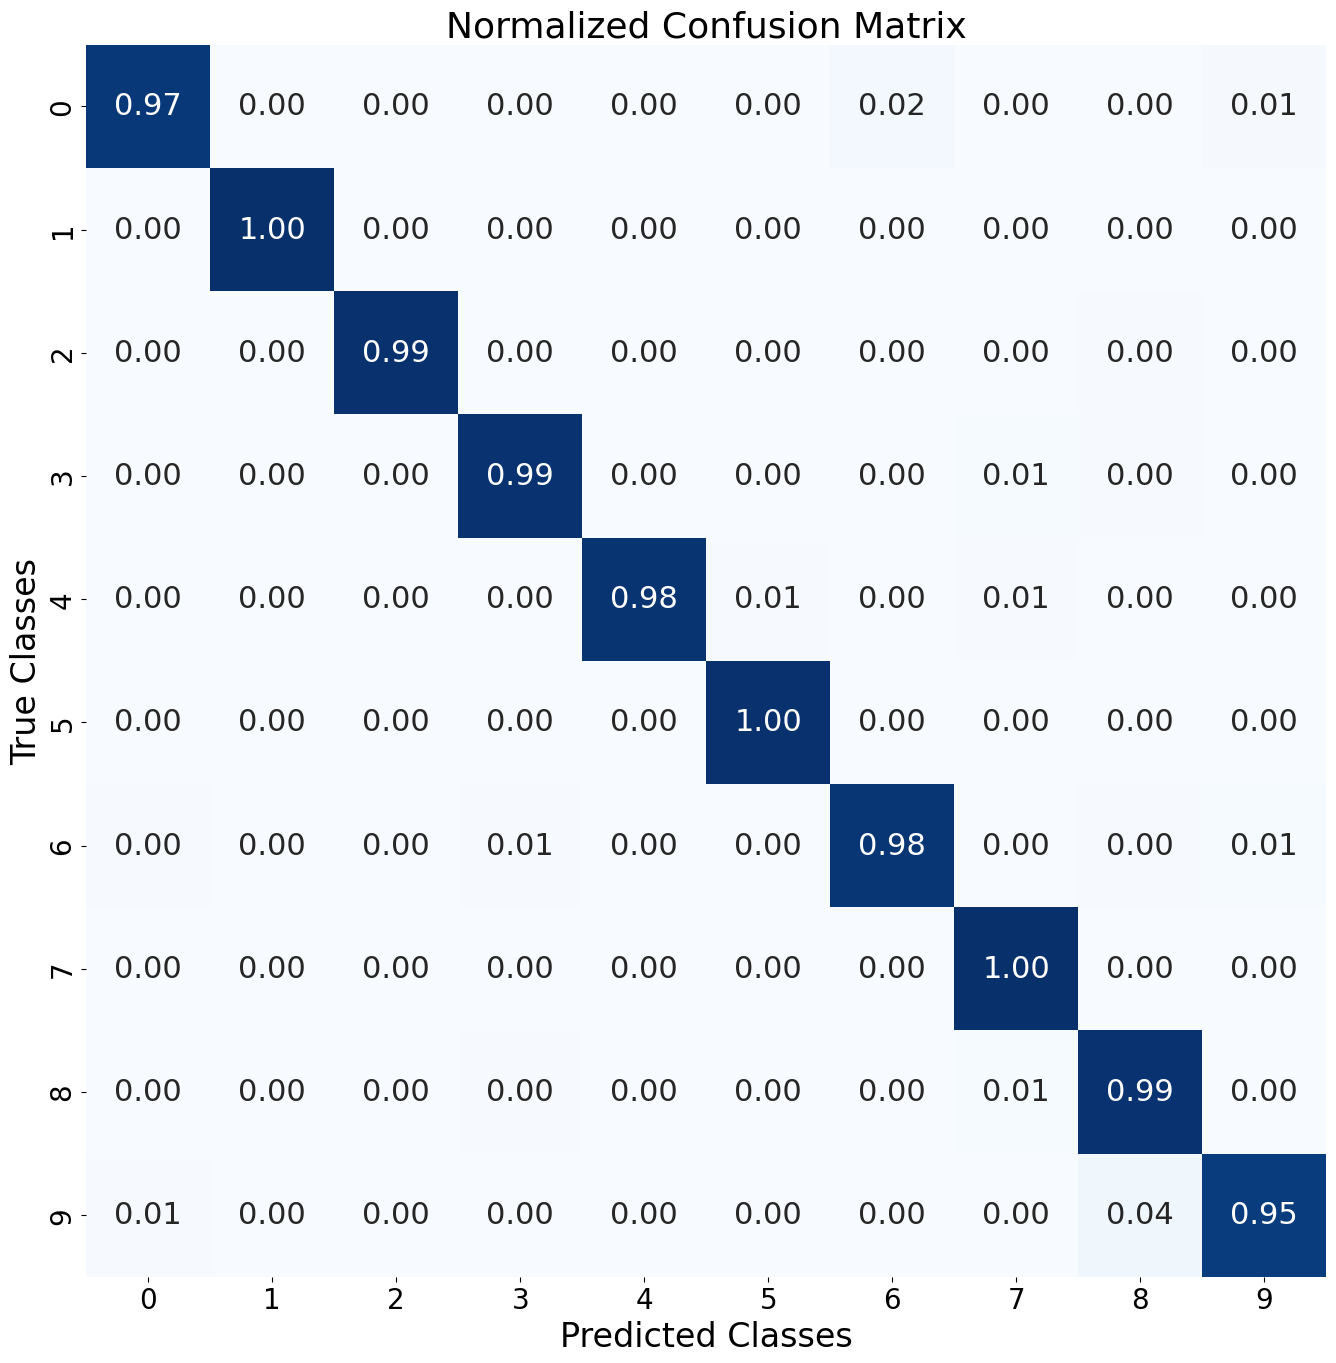

              precision    recall  f1-score   support

           F       0.99      0.97      0.98       500
           G       1.00      1.00      1.00       500
           H       1.00      0.99      1.00       500
           I       0.99      0.99      0.99       500
           J       1.00      0.98      0.99       500
           K       0.99      1.00      1.00       500
           L       0.97      0.98      0.98       500
           M       0.98      1.00      0.99       500
           N       0.95      0.99      0.97       500
           O       0.97      0.95      0.96       500

    accuracy                           0.98      5000
   macro avg       0.98      0.98      0.98      5000
weighted avg       0.98      0.98      0.98      5000



In [33]:
plt.figure(figsize = (16, 16))
sns.heatmap(confusionmatrix, cmap = 'Blues', annot = True, fmt="d", cbar = False, annot_kws={"size": 22},)
plt.title('Confusion Matrix', fontsize=26)
plt.ylabel('True Classes', fontsize=24)
plt.xlabel('Predicted Classes', fontsize=24)
plt.xticks(fontsize=20)
plt.yticks(fontsize=20)

print(classification_report(true_classes, predicted_classes))

# Normalize confusion matrix by row (i.e., by the number of true labels in each class)
normalized_confusionmatrix = confusionmatrix.astype('float') / confusionmatrix.sum(axis=1)[:, np.newaxis]

# Plot normalized confusion matrix
plt.figure(figsize=(16, 16))
sns.heatmap(normalized_confusionmatrix, cmap='Blues', annot=True, fmt=".2f", cbar=False, annot_kws={"size": 22})
plt.title('Normalized Confusion Matrix', fontsize=26)
plt.ylabel('True Classes', fontsize=24)
plt.xlabel('Predicted Classes', fontsize=24)
plt.xticks(fontsize=20)
plt.yticks(fontsize=20)
plt.show()
# Print classification report
print(classification_report(true_classes, predicted_classes, target_names=class_labels))